<a href="https://colab.research.google.com/github/urvog/NLP-Sentiment-Analysis/blob/main/NLP_BERT_Fine_Tuning_All%20(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install transformers
!unzip data.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/sem_eval_test_blank_es.csv  
  inflating: __MACOSX/data/._sem_eval_test_blank_es.csv  
  inflating: data/sem_eval_train_es.csv  
  inflating: __MACOSX/data/._sem_eval_train_es.csv  
  inflating: data/df_anger.csv       
  inflating: __MACOSX/data/._df_anger.csv  
  inflating: data/df_anticipation.csv  
  inflating: __MACOSX/data/._df_anticipation.csv  
  inflating: data/df_disgust.csv     
  inflating: __MACOSX/data/._df_disgust.csv  
  inflating: data/df_fear.csv        
  inflating: __MACOSX/data/._df_fear.csv  
  inflating: data/df_joy.csv         
  inflating: __MACOSX/data/._df_joy.csv  
  inflating: data/df_love.csv        
  inflating: __MACOSX/data/._df_love.csv  
  inflating: data/df_optimism.csv    
  inflating: __MACOSX/data/._df_optimism.csv  
  inflating: data/df_pessimism.csv   
  i

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertConfig, TFBertForSequenceClassification
import tensorflow as tf

from sklearn.model_selection import train_test_split

pd.options.display.max_colwidth = None
%matplotlib inline

In [11]:
#modelo transformer a utilizar
nombre_modelo = 'bert-base-multilingual-uncased'

In [12]:
sent_list = ['anger','anticipation','disgust','fear','joy','love','optimism','pessimism','sadness','surprise','trust']
sent_list

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

## Limpieza de datos

In [13]:
import re, string

pattern1 = re.compile(r'@[\w_]+') #elimina menciones
pattern2 = re.compile(r'https?://[\w_./]+') #elimina URL
pattern3 = re.compile(r'#[\w_]+') #elimina hashtags
pattern4 = re.compile('[{}]+'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text):
    """Limpiamos las menciones, URL y hashtags del texto. Luego 
    quitamos signos de puntuación"""
    text = pattern1.sub('mención', text)
    text = pattern2.sub('URL', text)
    text = pattern3.sub('hashtag', text)
    text = pattern4.sub(' ', text)
    
    return text

## Fine Tunning con BERT

In [14]:
#definimos modelo de clasificación
config = BertConfig.from_pretrained(nombre_modelo, hidden_dropout_prob=0.1, num_labels=2)
model = TFBertForSequenceClassification.from_pretrained(nombre_modelo, config=config)
model.bert.trainable = True #Forzamos a entrenar, puesto que congelando no aprende el modelo

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5

learning_rate = 2e-5

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  167356416 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

--------------------TRAINING SENTIMENT: anger---------------------
Epoch 1/2
312/312 [==============================] - 64s 121ms/step - loss: 0.5809 - accuracy: 0.7039 - val_loss: 0.5866 - val_accuracy: 0.6791
Epoch 2/2
312/312 [==============================] - 35s 113ms/step - loss: 0.4084 - accuracy: 0.8198 - val_loss: 0.6072 - val_accuracy: 0.6922


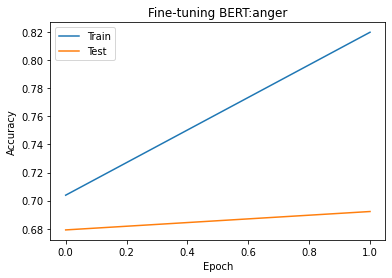

134/134 - 5s - loss: 0.6072 - accuracy: 0.6922 - 5s/epoch - 36ms/step
Evaluacion Modelo Sentimiento: anger
score: 0.61
acc: 0.69
--------------------TRAINING SENTIMENT: anticipation---------------------
Epoch 1/2
312/312 [==============================] - 35s 112ms/step - loss: 0.3735 - accuracy: 0.8736 - val_loss: 0.3524 - val_accuracy: 0.8840
Epoch 2/2
193/312 [=================>............] - ETA: 12s - loss: 0.3211 - accuracy: 0.8860

KeyboardInterrupt: ignored

In [15]:
#main Loop
df_test = pd.read_csv('data/sem_eval_test_blank_es.csv')
tokenizer = BertTokenizer.from_pretrained(nombre_modelo)

#preparamos el final test
df_test.Tweet = df_test.Tweet.apply(clean_text)
df_test = df_test[df_test['Tweet']!='']

final_predictions = []


for data in sent_list:
    ###PREPARANDO EL DATASET-------------------------------------------------------------
    #limpiamos texto y quitamos tweets que se han quedado vacíos
    df = pd.read_csv("data/df_"+data+".csv")
    
    df.Tweet=df.Tweet.apply(clean_text)
    df = df[df['Tweet']!='']
    #el conjunto de salida es la polaridad, hay que convertir a binario
    #codificamos 'P' como 1 y 'N' se queda como 0
    Y=df.iloc[:,1:]

    #Separamos entrenamiento y test
    #realmente habría que sacar los tokens sólo del conjunto de entrenamiento...
    X_train_tweets, X_test_tweets, Y_train, Y_test = train_test_split(df.Tweet,Y, test_size = 0.3, random_state = 42)
    #print(X_train_tweets.shape,Y_train.shape)
    #print(X_test_tweets.shape,Y_test.shape)

    #preparamos el final test
    df_test.Tweet = df_test.Tweet.apply(clean_text)
    df_test = df_test[df_test['Tweet']!='']
    #print(df_test.Tweet.shape)
    
    ##PREPARAMOS LOS DATOS PARA ENTRADA AL MODELO-----------------------------------------
    #Tokenizamos y codificamos como Dataset

    train_encodings = tokenizer(X_train_tweets.to_list(), truncation=True, padding=True, return_tensors="tf")
    MAX_SEQUENCE_LENGTH=train_encodings['input_ids'].shape[1]
    test_encodings = tokenizer(X_test_tweets.to_list(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")
    test_final_encondings = tokenizer(df_test.Tweet.to_list(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")
    
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        Y_train
    ))
    test_dataset = tf.data.Dataset.from_tensor_slices((
        dict(test_encodings),
        Y_test
    ))
    
    final_test_dataset = tf.data.Dataset.from_tensor_slices((
        dict(test_final_encondings),
    ))

    
    ##TRAINING----------------------------------------------------------------------------
    batch_size=8
    
    print("--------------------TRAINING SENTIMENT: "+data+"---------------------")
    history=model.fit(train_dataset.batch(batch_size), epochs=2, batch_size=batch_size, validation_data=test_dataset.batch(batch_size))
    
    ##VISUALIZANDO EL ENTRENAMIENTO-------------------------------------------------------
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Fine-tuning BERT:'+data)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    
    ##EVALUACION DEL MODELO -------------------------------------------------------------
    score,acc = model.evaluate(test_dataset.batch(batch_size), verbose = 2, batch_size = batch_size)
    print("Evaluacion Modelo Sentimiento: "+data)
    print("score: %.2f" % (score))
    print("acc: %.2f" % (acc))
    
    ##PREDICTIONS FOR TEST DATASET
    #obtenemos las predicciones del modelo sobre el dataset de test final
    predict=model.predict(final_test_dataset.batch(batch_size))
    
    predict_proba = tf.nn.softmax(predict.logits)
    predict_clases = np.argmax(predict_proba, 1)
    
    final_predictions.append(predict_clases)
    
    